In [2]:
import os
import glob
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, losses, metrics, regularizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K 
from keras.engine.topology import Container


/home/duke/.conda/envs/heads/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [6]:
from keras.datasets import mnist

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

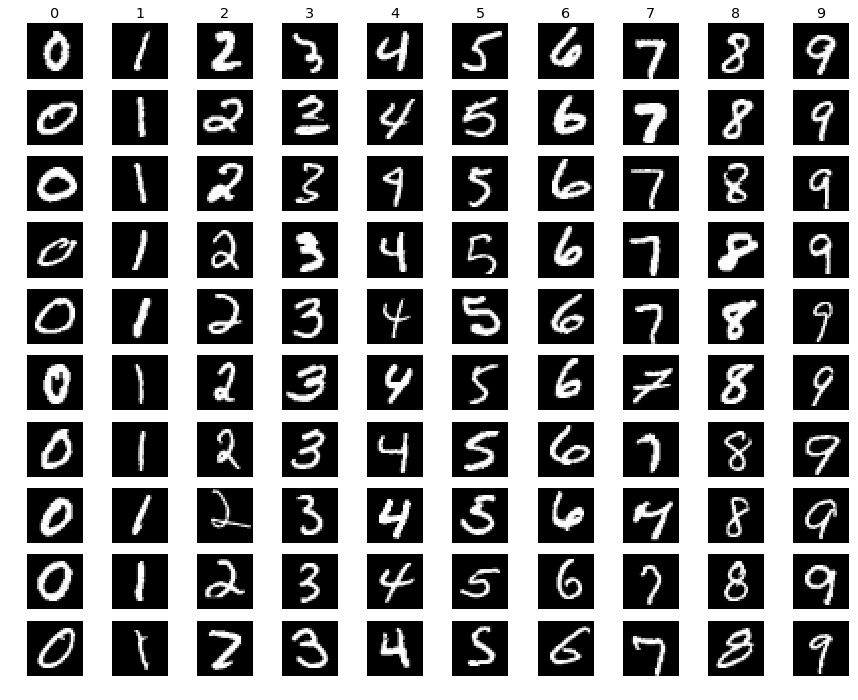

In [9]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
class GradNorm(layers.Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        super(GradNorm, self).build(input_shapes)

    def call(self, inputs):
        target, image = inputs
        
        # Впишите код сюда
        
        return None # Не забудьту заменить

    def compute_output_shape(self, input_shapes):
        return (input_shapes[1][0], 1)

In [11]:
class MixtureLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MixtureLayer, self).__init__(**kwargs)

    def build(self, input_shapes):
        super(MixtureLayer, self).build(input_shapes)

    def call(self, inputs):
        image_real, image_fake = inputs

        # Впишите код сюда
        
        return None # Не забудьту заменить 

    def compute_output_shape(self, input_shapes):
        return input_shapes[0]

In [12]:
class WasserstainLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(WasserstainLayer, self).__init__(**kwargs)

    def build(self, input_shapes):
        super(WasserstainLayer, self).build(input_shapes)

    def call(self, inputs):
        score_real, score_fake = inputs
        
        # Впишите код сюда
        
        return None # Не забудьту заменить на верное значние

    def compute_output_shape(self, input_shapes):
        return input_shapes[0]

In [13]:
def build_classifier():
    img_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(img_input)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(64, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
    
    fake_detector_output = layers.GlobalAveragePooling2D(name='fake_detector_output')(x)
    
    return models.Model(img_input, fake_detector_output, 
                        name='classifier')

In [14]:
def build_critic():
    img_input_real = layers.Input(shape=(28, 28, 1))
    img_input_fake = layers.Input(shape=(28, 28, 1))
    
    classifier = build_classifier()
    
    score_real = classifier(img_input_real)
    score_fake = classifier(img_input_fake)
    
    wasserstain_loss = WasserstainLayer(name='wasserstain_loss')([score_real, score_fake])
    
    img_mixture = MixtureLayer()([img_input_real, img_input_fake])
    
    score_mix = classifier([img_mixture])
    grad_norm = GradNorm(name='grad_norm')([score_mix, img_mixture])
    
    return models.Model([img_input_real, img_input_fake], [wasserstain_loss, grad_norm]), classifier
    

In [15]:
def multiple_loss(y_true, y_pred):
    return K.mean(y_true*y_pred, axis=-1)

In [16]:
def wgan_penalty_loss(y_true, y_pred):
    #https://arxiv.org/pdf/1709.08894.pdf
    return K.mean(K.square(K.maximum(0., y_pred - y_true)), axis=-1)

In [17]:
K.clear_session()
with tf.variable_scope('discriminator'):
    critic, classifier = build_critic()

    adam = optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.99)
    classifier.compile(adam, loss=[multiple_loss])
    critic.compile(adam, 
                  loss=[multiple_loss, wgan_penalty_loss],
                  metrics=['acc'], loss_weights=[1, 10])

# А теперь генератор 

In [18]:
def build_generator():
    z_input = layers.Input(shape=(128,))
    
    x = layers.Dense(512)(z_input)
    x = layers.BatchNormalization()(x)
    x = layers.ELU()(x)
    x = layers.Dense(7 * 7 * 64)(x)
    x = layers.ELU()(x)
    x = layers.Reshape((7, 7, 64))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.ELU()(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.ELU()(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.ELU()(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.ELU()(x)
    
    x = layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(x)
    
    return models.Model(z_input, x)

In [19]:
def build_gan_generator(classifier):
    z_input = layers.Input(shape=(128,))
    
    generator = build_generator()
    
    output = generator(z_input)
    
    score = classifier(output)
    
    return models.Model(z_input, score), generator

In [20]:
with tf.variable_scope('generator'):
    classifier.trainable = False
    gan_generator, generator = build_gan_generator(classifier)
    adam = optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.99)
    gan_generator.compile(adam, 
                  loss=[multiple_loss],
                  metrics=['acc'])
    classifier.trainable = True

In [21]:
import threading
class threadsafe_iter():
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """

    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)


def threadsafe_generator(f):

    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))

    return g

In [22]:
@threadsafe_generator
def geterate_batch_critic(data, batch_size=128):
    data = (data - 127.5) / 127.5
    while True:
        np.random.shuffle(data)
        bathes = np.array_split(data, len(data) // batch_size)
    
        for batch in bathes:
            z = np.random.rand(len(batch), 128).astype(np.float32)

            generated_frames = generator.predict([z])

            was_label = np.array([1]*len(batch))
            norm_val = np.array([1]*len(batch))

            yield [np.expand_dims(batch, -1), generated_frames], [was_label, norm_val]

In [23]:
@threadsafe_generator
def geterate_batch_generator(batch_size=128):
    while True:
        z = np.random.rand(batch_size, 128).astype(np.float32)
        score = np.array([-1] * batch_size)
        yield z, score

In [154]:
train_gen_critic = geterate_batch_critic(x_train, 128)
train_gen_generator = geterate_batch_generator(128)

Тренировочный цикл

In [156]:
from keras import callbacks as cbks, models
# noinspection PyProtectedMember
def fit_generator(gan_generator : models.Model,
                  gan_critic : models.Model,
                  gen_generator,
                  critic_generator,
                  steps_per_epoch=None,
                  n_gen = 10,
                  epochs=256,
                  verbose=1,
                  gen_callbacks=None,
                  critic_callbacks=None,
                  initial_epoch=0):
    k = 0
    epoch = initial_epoch

    if steps_per_epoch is None:
        ValueError('`steps_per_epoch=None` is only valid for a'
                   ' generator based on the `keras.utils.Sequence`'
                   ' class. Please specify `steps_per_epoch` or use'
                   ' the `keras.utils.Sequence` class.')

    # Prepare display labels.
    out_labels = [f'generator_{m}' for m in gan_generator._get_deduped_metrics_names()] + \
                 [f'critic_{m}' for m in gan_critic._get_deduped_metrics_names()]
    callback_metrics = out_labels 

    gen_callback_model, gen_callbacks = prepare_callbacks(gan_generator,
                                                          gen_callbacks,
                                                          callback_metrics,
                                                          epochs,
                                                          steps_per_epoch,
                                                          verbose)
    gen_callbacks.on_train_begin()

    critic_callback_model, critic_callbacks = prepare_callbacks(gan_critic,
                                                                critic_callbacks,
                                                                callback_metrics,
                                                                epochs,
                                                                steps_per_epoch,
                                                                verbose)
    gen_callbacks.on_train_begin()
    critic_callbacks.on_train_begin()

    gen_callback_model.stop_training = False
    critic_callback_model.stop_training = False
    if not hasattr(gen_callback_model, 'log_values'):
        gen_callback_model.log_values = []
    if not  hasattr(critic_callback_model,'log_values'):
        critic_callback_model.log_values = []
    while epoch < epochs:
        gen_callbacks.on_epoch_begin(epoch)
        critic_callbacks.on_epoch_begin(epoch)

        steps_done = 0
        batch_index = 0
        
        gen_outs = []
        while steps_done < steps_per_epoch:
            generator_output = next(critic_generator)

            sample_weight, x, y = validate_output(generator_output)

            # build batch logs
            batch_logs = {}
            if isinstance(x, list):
                batch_size = x[0].shape[0]
            elif isinstance(x, dict):
                batch_size = list(x.values())[0].shape[0]
            else:
                batch_size = x.shape[0]

            batch_logs['batch'] = batch_index
            batch_logs['size'] = batch_size

            critic_callbacks.on_batch_begin(batch_index, batch_logs)
            critic_outs = gan_critic.train_on_batch(x, y)

            
            if batch_index % n_gen == 0 or batch_index != 0:
                gen_callbacks.on_batch_begin(batch_index, batch_logs)
                
                gen_generator_output = next(gen_generator)
                _, x_gen, y_gen = validate_output(gen_generator_output)

                gen_outs = gan_generator.train_on_batch(x_gen, y_gen)

            outs = gen_outs + critic_outs
            for l, o in zip(out_labels, outs):
                batch_logs[l] = o

            gen_callbacks.on_batch_end(batch_index, batch_logs)
            critic_callbacks.on_batch_end(batch_index, batch_logs)

            # Construct epoch logs.
            epoch_logs = {}
            batch_index += 1
            steps_done += 1

            if gen_callback_model.stop_training:
                break
            if critic_callback_model.stop_training:
                break

        gen_callbacks.on_epoch_end(epoch, epoch_logs)
        critic_callbacks.on_epoch_end(epoch, epoch_logs)

        epoch += 1
        if critic_callback_model.stop_training:
            break
        if gen_callback_model.stop_training:
            break

    gen_callbacks.on_train_end()
    critic_callbacks.on_train_end()
    return critic_callback_model.history, gen_callback_model.history


def validate_output(generator_output):
    if len(generator_output) == 2:
        x, y = generator_output
        sample_weight = None
    else:
        raise ValueError('Output of generator should be '
                         'a tuple `(x, y, sample_weight)` '
                         'or `(x, y)`. Found: ' +
                         str(generator_output))
    return sample_weight, x, y


def prepare_callbacks(model, callbacks, callback_metrics, epochs, steps_per_epoch, verbose):
    # prepare callbacks
    model.history = cbks.History()
    callbacks = [cbks.BaseLogger()] + (callbacks or []) + [model.history]
    if verbose:
        callbacks += [cbks.ProgbarLogger(count_mode='steps')]
    callbacks = cbks.CallbackList(callbacks)
    if hasattr(model, 'callback_model'):
        callback_model = model.callback_model
    else:
        callback_model = model
    callbacks.set_model(callback_model)
    callbacks.set_params({
        'epochs': epochs,
        'steps': steps_per_epoch,
        'verbose': verbose,
        'metrics': callback_metrics,
    })
    return callback_model, callbacks

In [160]:
from keras.callbacks import Callback
j = None
class SaveImageSamplesCallback(Callback):
    def __init__(self, gen, log_dir='./logs'):
        super(SaveImageSamplesCallback, self).__init__()
        if K.backend() != 'tensorflow':
            raise RuntimeError('TensorBoard callback only works ''with the TensorFlow backend.')
        self.log_dir = log_dir
        self.gen = gen
        
    def set_model(self, model):
        self.model = model.layers[1]
        self.sess = K.get_session()
        self.placeholder = tf.placeholder(tf.float32, shape=(None,28,28,1))
        self.summary_image = tf.summary.image('results', self.placeholder, max_outputs=3)
        self.writer = tf.summary.FileWriter(self.log_dir)
   
    def on_epoch_end(self, epoch, logs={}):
        

        inps = next(self.gen)[0]
        output = self.model.predict(inps)
        summary=self.sess.run(self.summary_image, {self.placeholder: output})
        self.writer.add_summary(summary, epoch)
        self.writer.flush()

In [161]:
save_dir = 'hse_wgan_mnist/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(save_dir + 'checkpoints')

image_callback = SaveImageSamplesCallback(train_gen_generator, save_dir + 'img')

critic_callbacks = [
    ModelCheckpoint(save_dir + 'checkpoints/critic-{epoch:02d}.h5', verbose=1, monitor='critic_loss'),
    TensorBoard(log_dir=save_dir + 'critic'),#, write_grads=True, histogram_freq=5),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, epsilon=0.01, verbose=1, monitor='critic_loss')
]

gen_callbacks = [
    ModelCheckpoint(save_dir + 'checkpoints/gen_{epoch:02d}.h5', monitor='generator_loss', verbose=1),
    TensorBoard(log_dir=save_dir + 'generator'),#, write_grads=True, histogram_freq=5),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, epsilon=0.01, verbose=1, monitor='generator_loss'),
    image_callback
]

In [162]:
fit_generator(gan_generator,
              critic, 
              gen_generator=train_gen_generator, 
              epochs= 256, 
              critic_generator=train_gen_critic, 
              steps_per_epoch=64, 
              gen_callbacks=gen_callbacks, 
              critic_callbacks=critic_callbacks)

Epoch 1/256
Epoch 1/256
 1/64 [..............................] - ETA: 19s - generator_loss: 11.6690 - generator_acc: 0.0000e+00 - critic_loss: -0.3492 - critic_wasserstain_loss_loss: -0.3509 - critic_grad_norm_loss: 1.7054e-04 - critic_wasserstain_loss_acc: 0.2016 - critic_grad_norm_acc: 1.0000

/home/duke/.conda/envs/heads/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


64/64 [==============================] - 14s 216ms/step - generator_loss: 11.1948 - generator_acc: 0.0000e+00 - critic_loss: -0.3579 - critic_wasserstain_loss_loss: -0.3699 - critic_grad_norm_loss: 0.0012 - critic_wasserstain_loss_acc: 0.1760 - critic_grad_norm_acc: 1.0000
Epoch 00001: saving model to /home/duke/Documents/artefacts/hse_wgan_mnist/checkpoints/critic-01.h5
64/64 [==============================] - 14s 217ms/step - generator_loss: 11.1948 - generator_acc: 0.0000e+00 - critic_loss: -0.3579 - critic_wasserstain_loss_loss: -0.3699 - critic_grad_norm_loss: 0.0012 - critic_wasserstain_loss_acc: 0.1760 - critic_grad_norm_acc: 1.0000
Epoch 2/256
Epoch 2/256
64/64 [==============================] - 14s 212ms/step - generator_loss: 11.1145 - generator_acc: 0.0000e+00 - critic_loss: -0.2630 - critic_wasserstain_loss_loss: -0.2729 - critic_grad_norm_loss: 9.8735e-04 - critic_wasserstain_loss_acc: 0.1840 - critic_grad_norm_acc: 1.0000
Epoch 00002: saving model to /home/duke/Documents/

Epoch 9/256
Epoch 9/256
64/64 [==============================] - 14s 214ms/step - generator_loss: 11.8169 - generator_acc: 0.0000e+00 - critic_loss: -0.2979 - critic_wasserstain_loss_loss: -0.3085 - critic_grad_norm_loss: 0.0011 - critic_wasserstain_loss_acc: 0.1864 - critic_grad_norm_acc: 1.0000
Epoch 00009: saving model to /home/duke/Documents/artefacts/hse_wgan_mnist/checkpoints/critic-09.h5
64/64 [==============================] - 14s 215ms/step - generator_loss: 11.8169 - generator_acc: 0.0000e+00 - critic_loss: -0.2979 - critic_wasserstain_loss_loss: -0.3085 - critic_grad_norm_loss: 0.0011 - critic_wasserstain_loss_acc: 0.1864 - critic_grad_norm_acc: 1.0000
Epoch 10/256
Epoch 10/256
64/64 [==============================] - 14s 214ms/step - generator_loss: 11.3692 - generator_acc: 0.0000e+00 - critic_loss: -0.3298 - critic_wasserstain_loss_loss: -0.3394 - critic_grad_norm_loss: 9.5581e-04 - critic_wasserstain_loss_acc: 0.1801 - critic_grad_norm_acc: 1.0000
Epoch 00010: saving mode

Epoch 17/256
Epoch 17/256
64/64 [==============================] - 14s 213ms/step - generator_loss: 10.7783 - generator_acc: 0.0000e+00 - critic_loss: -0.1948 - critic_wasserstain_loss_loss: -0.2026 - critic_grad_norm_loss: 7.8190e-04 - critic_wasserstain_loss_acc: 0.1681 - critic_grad_norm_acc: 1.0000
Epoch 00017: saving model to /home/duke/Documents/artefacts/hse_wgan_mnist/checkpoints/critic-17.h5
64/64 [==============================] - 14s 214ms/step - generator_loss: 10.7783 - generator_acc: 0.0000e+00 - critic_loss: -0.1948 - critic_wasserstain_loss_loss: -0.2026 - critic_grad_norm_loss: 7.8190e-04 - critic_wasserstain_loss_acc: 0.1681 - critic_grad_norm_acc: 1.0000
Epoch 18/256
Epoch 18/256
64/64 [==============================] - 14s 216ms/step - generator_loss: 10.8960 - generator_acc: 0.0000e+00 - critic_loss: -0.2267 - critic_wasserstain_loss_loss: -0.2371 - critic_grad_norm_loss: 0.0010 - critic_wasserstain_loss_acc: 0.1401 - critic_grad_norm_acc: 1.0000
Epoch 00018: savin

Epoch 25/256
Epoch 25/256
64/64 [==============================] - 13s 208ms/step - generator_loss: 10.6775 - generator_acc: 0.0000e+00 - critic_loss: -0.3334 - critic_wasserstain_loss_loss: -0.3423 - critic_grad_norm_loss: 8.8766e-04 - critic_wasserstain_loss_acc: 0.1584 - critic_grad_norm_acc: 1.0000
Epoch 00025: saving model to /home/duke/Documents/artefacts/hse_wgan_mnist/checkpoints/critic-25.h5
64/64 [==============================] - 13s 209ms/step - generator_loss: 10.6775 - generator_acc: 0.0000e+00 - critic_loss: -0.3334 - critic_wasserstain_loss_loss: -0.3423 - critic_grad_norm_loss: 8.8766e-04 - critic_wasserstain_loss_acc: 0.1584 - critic_grad_norm_acc: 1.0000
Epoch 26/256
Epoch 26/256
64/64 [==============================] - 13s 208ms/step - generator_loss: 11.1943 - generator_acc: 0.0000e+00 - critic_loss: -0.4589 - critic_wasserstain_loss_loss: -0.4688 - critic_grad_norm_loss: 9.8231e-04 - critic_wasserstain_loss_acc: 0.1232 - critic_grad_norm_acc: 1.0000
Epoch 00026: s

Epoch 33/256
Epoch 33/256
64/64 [==============================] - 13s 208ms/step - generator_loss: 11.8751 - generator_acc: 0.0000e+00 - critic_loss: -0.4652 - critic_wasserstain_loss_loss: -0.4806 - critic_grad_norm_loss: 0.0015 - critic_wasserstain_loss_acc: 0.1324 - critic_grad_norm_acc: 1.0000
Epoch 00033: saving model to /home/duke/Documents/artefacts/hse_wgan_mnist/checkpoints/critic-33.h5
64/64 [==============================] - 13s 208ms/step - generator_loss: 11.8751 - generator_acc: 0.0000e+00 - critic_loss: -0.4652 - critic_wasserstain_loss_loss: -0.4806 - critic_grad_norm_loss: 0.0015 - critic_wasserstain_loss_acc: 0.1324 - critic_grad_norm_acc: 1.0000
Epoch 34/256
Epoch 34/256
64/64 [==============================] - 13s 208ms/step - generator_loss: 11.9799 - generator_acc: 0.0000e+00 - critic_loss: -0.4504 - critic_wasserstain_loss_loss: -0.4627 - critic_grad_norm_loss: 0.0012 - critic_wasserstain_loss_acc: 0.1075 - critic_grad_norm_acc: 1.0000
Epoch 00034: saving model 

KeyboardInterrupt: 